## Visualizing Original Geoparser - Total

We have used the [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) with the original language model for finding the Name Entities for all Scottish Gazetteers, and select just the ones regarding with places. Later, once we have the locations entities, we have used the georesolver to resolve these locations.
                       
The query for running that we have used is the following: 

`sspark-submit --py-files defoe.zip defoe/run_queries.py nls_gaz.txt  nls -l query_distributed_topics.txt -n 16 `


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_Gazetteer/results_paper/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type([]) :
                        c_locs=locs[t].copy()
                        c_locs.append(t.split("-")[0])
                        c_locs.append(page)
                        c_locs.append(year)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [72]:
def plot_bar_places(df_group_places, plot_type='resolved'):
    # this is for plotting purpose
    index = np.arange(len(df_group_places['Place']))
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, df_group_places['Place'], rotation=80, fontsize=7)

    if plot_type == "resolved":
        plt.bar(index, df_group_places['count'], color='orange')
        plt.title('15 Places most mentioned using the Original Geoparser across all Scottitsh Gazetteer')
    else:
        plt.bar(index, df_group_places['count'], color='coral')
        plt.title('15 Places most mentioned but not resolved using Original Geoparser across all Scottitsh Gazetteer')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in nls_gaz.txt, which each corresponds to a book of the "Scottish Gazzeters"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities*.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (original_geoparser)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 

`Example:
     
    - edition: '1828'
      georesolution_page:
       Aberdeen-rb19:
        - '57.1333333'
        - '-2.1'
       Edinburgh-rb7:
        - '55.9497284685701'
        - '-3.19333076477051'
    
      lang_model: geoparser_original
      page_filename: alto/97351031.34.xml
      text_unit id: Page27
      title: Descriptive account of the principal towns in Scotland to accompany Wood's town atlas`


In [7]:
results=read_query_results('geoparser_original_total')

In [8]:
df_total= geresolution_dataframe(results)

year 1883
year 1868
year 1842
year 1846
year 1882
year 1848
year 1803
year 1825
year 1806
year 1838
year 1828
year 1901


In [9]:
df_total.head()

,Latitude,Longitude,Place,Page,Year
0,40.4350792,-77.5561012,SCOTLAND,Page9,1883
1,42.46972,-76.44611,LUDGATE,Page9,1883
2,40.2075899,-77.01636569999999,BROAD STREET,Page9,1883
3,57.1333333,-2.1,ABERDEEN,Page9,1883
4,51.33333,0.08333,LONDON,Page9,1883


**Important: Number of Places that has been identified!**

In [10]:
df_total[["Place"]].count()

Place    491756
dtype: int64

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [47]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')

**Important: Number of Places that has been identified but not resolved!**

Creating a dataframe, df_not_resolved for futher exploration at the end of the notebook

In [48]:
df_not_resolved=df_total.loc[df_total['Latitude'] == '']
df_not_resolved.count()

Latitude     55672
Longitude    55672
Place        55672
Page         55672
Year         55672
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [49]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     436084
Longitude    436084
Place        436084
Page         436084
Year         436084
dtype: int64

## Exploring the places resolved (with latitude and longitude)

**Important: New dataframe- df_resolved- with just the rows has been resolved!!**

In [50]:
df_resolved = df_total[df_total['Latitude'] != '']

In [51]:
df_resolved.count()

Latitude     436084
Longitude    436084
Place        436084
Page         436084
Year         436084
dtype: int64

Places names - forcing all to lower case, and later capitalize them

In [52]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [63]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
0,40.4350792,-77.5561012,Scotland,Page9,1883
1,42.46972,-76.44611,Ludgate,Page9,1883
2,40.2075899,-77.01636569999999,Broad street,Page9,1883
3,57.1333333,-2.1,Aberdeen,Page9,1883
4,51.33333,0.08333,London,Page9,1883
5,55.87194,-4.43306,Glasgow,Page9,1883
6,55.5,-4.25,Ayrshire,Page12,1883
7,57.16667,-2.1,Old aberdeen,Page12,1883
8,55.95,-3.3725,Edinburgh,Page13,1883
9,55.95,-3.3725,Edinburgh,Page13,1883


In [54]:
df_capitalized.groupby("Place").count()

,Latitude,Longitude,Page,Year
Place,,,,
A,1,1,1,1
A county,3,3,3,3
A' chailleach,1,1,1,1
A'chailleach,2,2,2,2
A'chleit,1,1,1,1
Aan,13,13,13,13
Aaron hill,2,2,2,2
Abb,1,1,1,1
Abbe,2,2,2,2


In [65]:
df_max_geolocations = df_capitalized[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   



#df_max_geolocations =df_filter.drop(0)
print(df_max_geolocations.count())
df_max_geolocations.head(15)


Latitude     20974
Longitude    20974
count        20974
dtype: int64


,Latitude,Longitude,count
16419,56,-4,6152
15975,55.8666667,-4.25,4674
16265,55.95,-3.3725,4454
17306,56.5,-4,4188
17102,56.39153,-3.43951,3650
16256,55.9497284685701,-3.19333076477051,2941
18306,57.1666667,-2.6666667,2761
16013,55.87194,-4.43306,2351
16263,55.95,-3.2,2347
9620,43.3013842,-98.866753,2285


In [66]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=['Earth', 'The moon', 'Meridian', 'Jupiter', 'Venus', 'Kingdom']
place_label, place_freq = label_freq_places(df_capitalized, df_max_geolocations, filter_list)
    

0 6152 Scotland
1 4674 Glasgow
2 4454 Edinburgh
3 4188 Perthshire
4 3650 Scotland
5 2941 Edinburgh
6 2761 Aberdeenshire
7 2351 Glasgow
8 2347 Edinburgh
9 2285 Tay
10 2278 Stirling
11 2261 Stirlingshire
12 2228 Dumfries
13 2058 Aberdeen
14 2054 Forfarshire
15 1986 Inverness
16 1871 Perth
17 1868 Lanarkshire
18 1807 Leith


In [67]:
#Visualizing the 15 places in a Bar plot
df_places = {'Place':place_label,'Place_freq':place_freq}
df_places_freq = pd.DataFrame(df_places)
df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   


df_group_places

,Place,count
11,Scotland,9802
3,Edinburgh,9742
5,Glasgow,7025
10,Perthshire,4188
1,Aberdeenshire,2761
14,Tay,2285
12,Stirling,2278
13,Stirlingshire,2261
2,Dumfries,2228
0,Aberdeen,2058


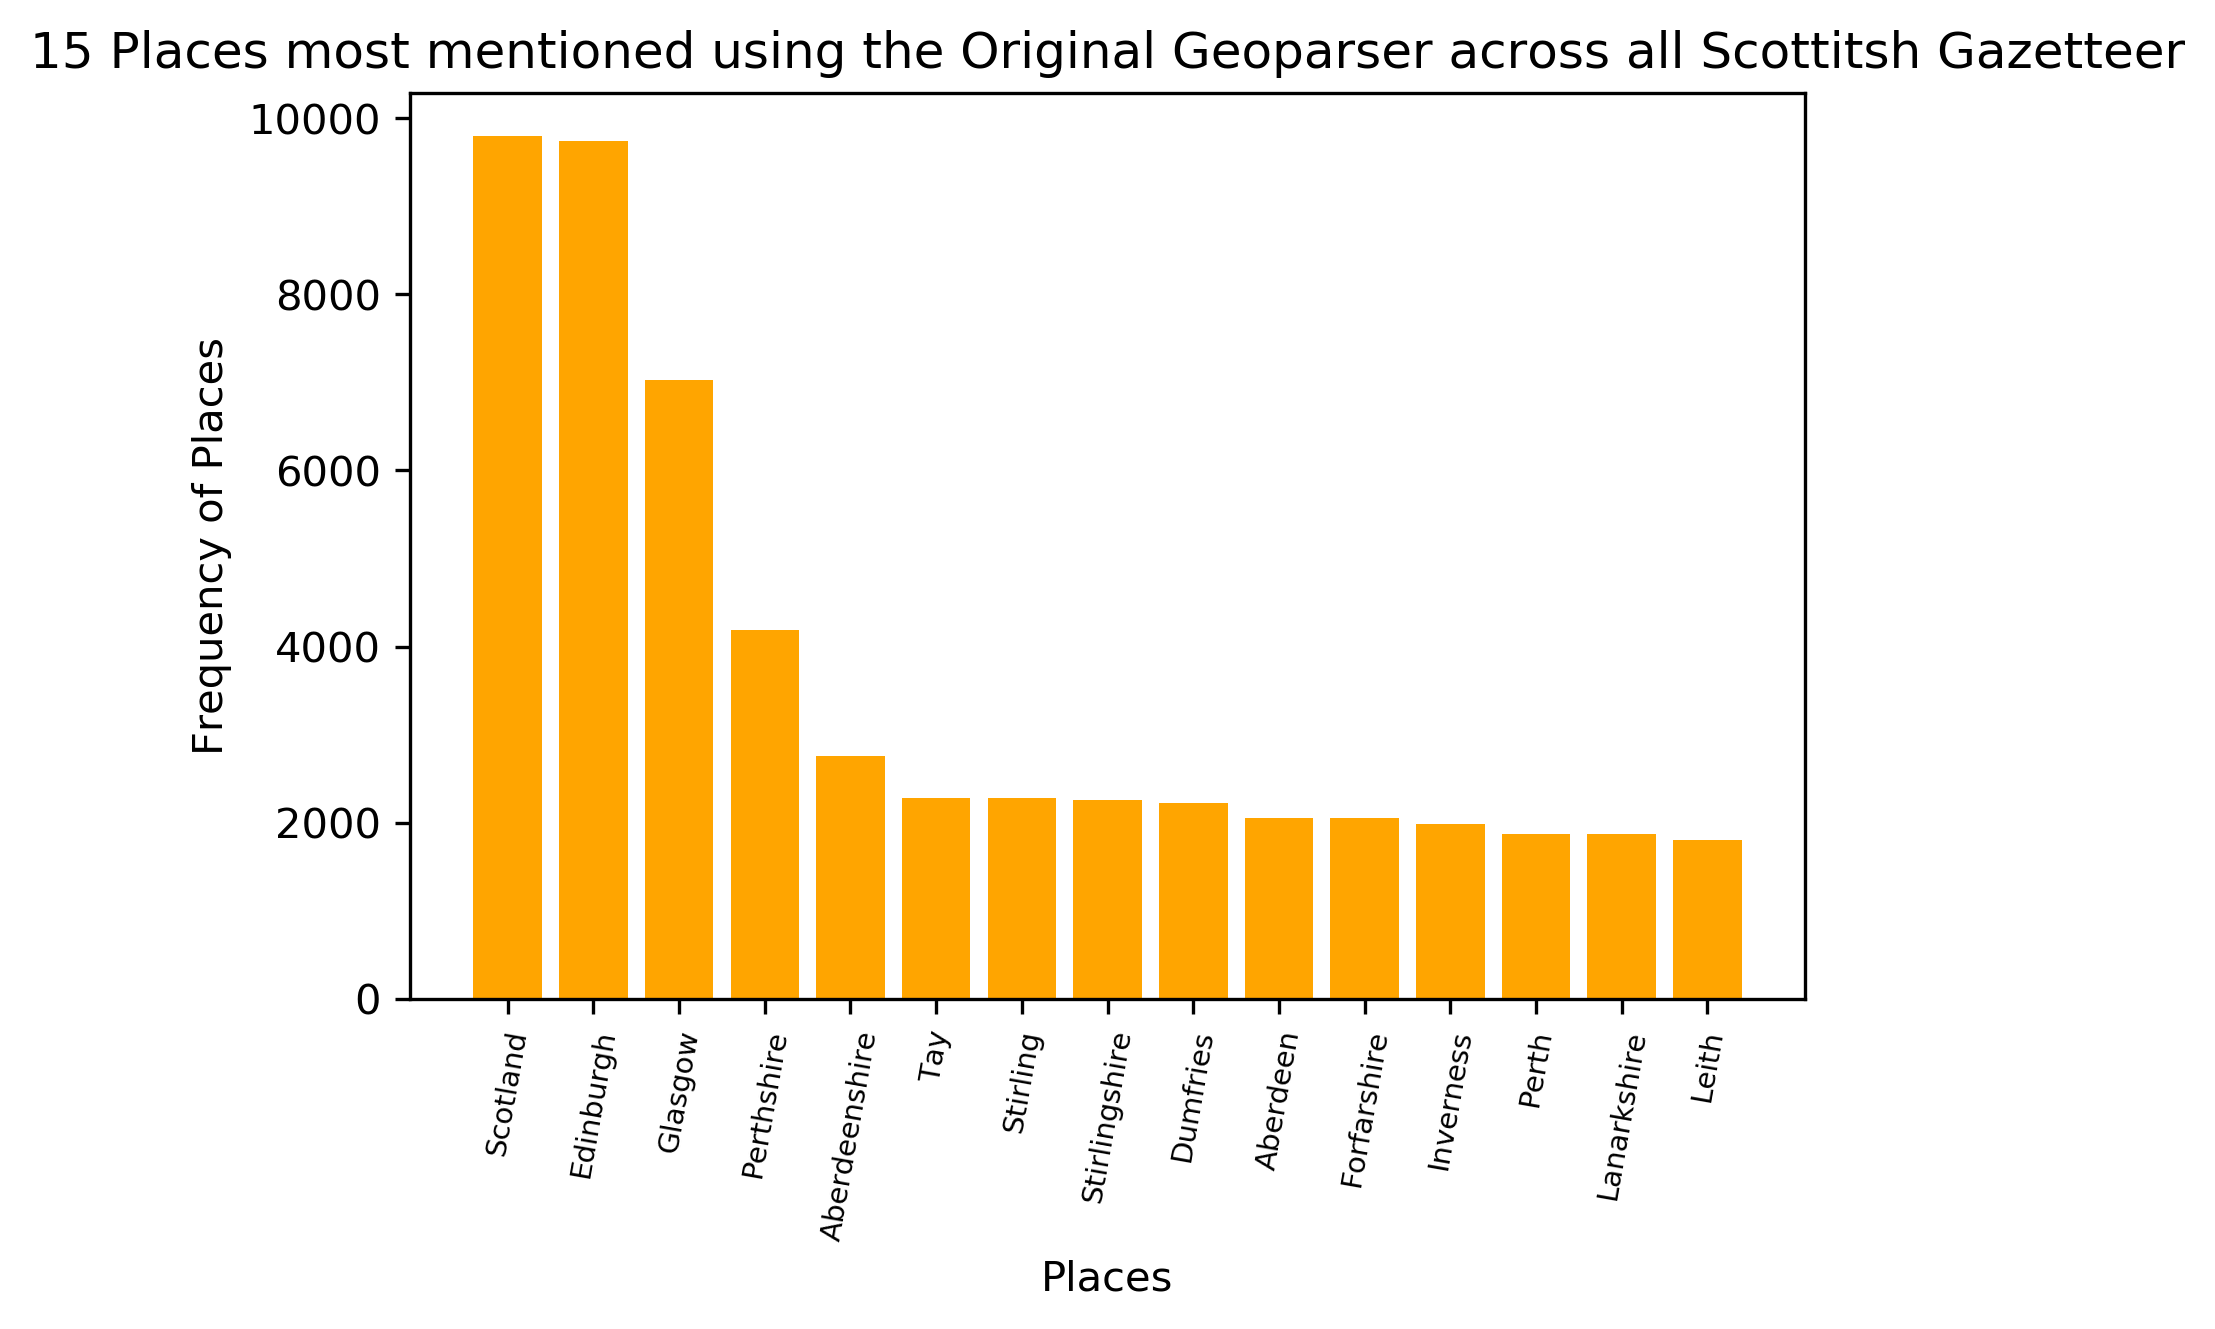

In [73]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(df_group_places, plot_type='resolved')

## Exploring the locations not resolved

Places names - forcing all to lower case, and later capitalize them

In [69]:
df4 = df_not_resolved.copy()
df4['Place']=df_not_resolved['Place'].apply(str.lower)

In [60]:
df_not_res_cap= df4.copy()
df_not_res_cap['Place']=df4['Place'].apply(str.capitalize)


In [70]:
df_not_resolved_max = df_not_res_cap[['Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

print(df_not_resolved_max.count())
df_not_resolved_max.head(15)

Place    15241
count    15241
dtype: int64


,Place,count
5207,Edinburghshire,1277
6555,Haddingtonshire,871
407,Argyleshire,851
8243,Linlithgowshire,653
14595,Tyne,420
6021,German ocean,292
3438,Cowgate,220
7185,Inverury,210
3826,Culdees,198
8267,Little dunkeld,179


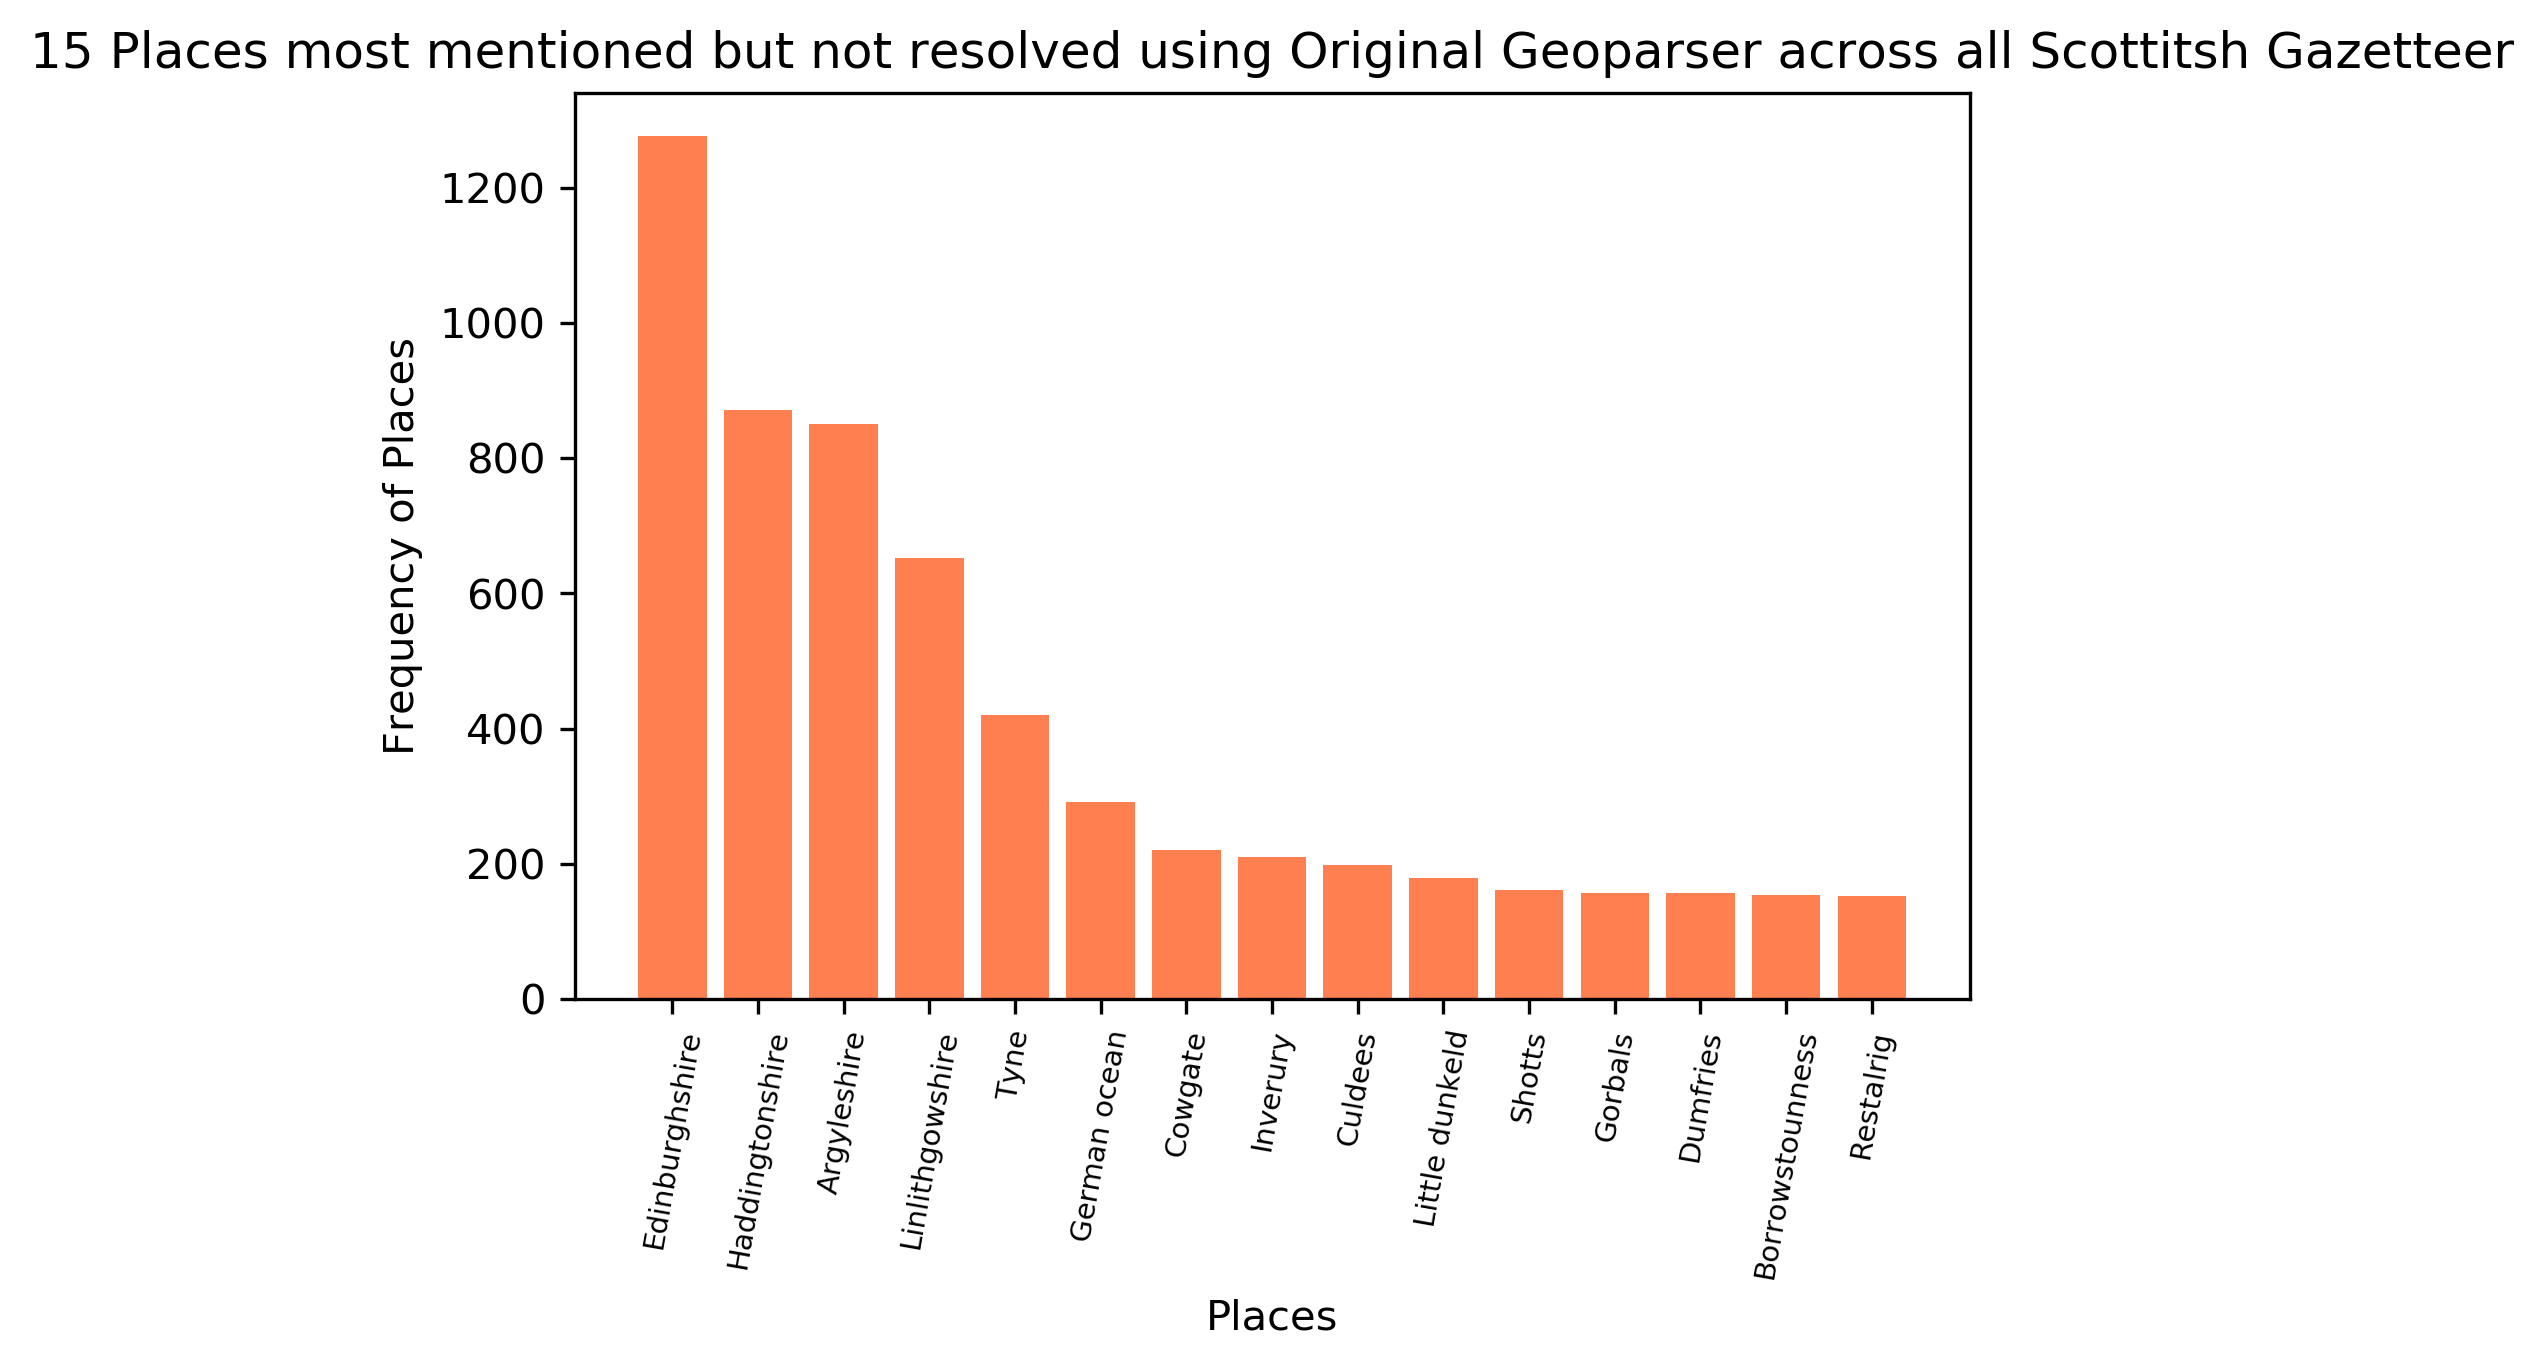

In [74]:
df_not_resolved_15 = df_not_resolved_max.head(15)
plot_bar_places(df_not_resolved_15, plot_type="not_resolved")